In [174]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from scipy.spatial.transform import Rotation as R

In [175]:
def _pad_to_common_shape(img):
    return np.pad(img, [[1280 - img.shape[0], 0], [0, 0], [0, 0]])

In [254]:
context_name = "17694030326265859208_2340_000_2360_000"
pred_path = f'./{context_name}'
image_path = f'/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_jpg/validation/{context_name}'

cam_extrinsic = np.load('cam_extrinsic.npy')# shape (5, 4, 4)
cam_intrinsic = np.load('cam_intrinsic.npy')# shape (3, 4, 4)
cam_distortion = np.load('cam_distortion.npy') # k1, k2, p1, p2, k3

cam_dict = {
    "img_FRONT" : 0,
    "img_FRONT_LEFT" : 1,
    "img_FRONT_RIGHT" : 2,
    "img_SIDE_LEFT" : 3,
    "img_SIDE_RIGHT" : 4
}

K = cam_intrinsic[0]
cam_name1 = "img_FRONT_RIGHT"
cam_extr1 = cam_extrinsic[cam_dict[cam_name1]]
R1 = cam_extr1[:3, :3]

cam_name2 = "img_SIDE_RIGHT"
cam_extr2 = cam_extrinsic[cam_dict[cam_name2]]
R2 = cam_extr2[:3, :3]

In [255]:
def getHomography(img1, img2, K, R1, R2):
    relative_R = R1 @ np.linalg.inv(R2)
    theta = R.from_matrix(relative_R).as_euler('xyz', degrees=False)
    r = R.from_euler('zxy', [-theta[0], theta[1], theta[2]], degrees=False)
    R_2to1 = r.as_matrix()
    H = K @ R_2to1 @ np.linalg.inv(K)
    H /= H[2][2]
    return H

def warpImage(img1, img2, H):
    img_stitch = cv2.warpPerspective(img2, H, (img2.shape[1]*2, img2.shape[0]))
    img_stitch[0:img1.shape[0], 0:img1.shape[1]] = img1
    return img_stitch

[[ 3.58157330e-01  1.23065396e-02  1.71075081e+03]
 [-2.21160016e-01  9.69750955e-01  6.97478907e+00]
 [-3.38200796e-04  7.66465408e-07  1.00000000e+00]]
(1280, 3840, 3)


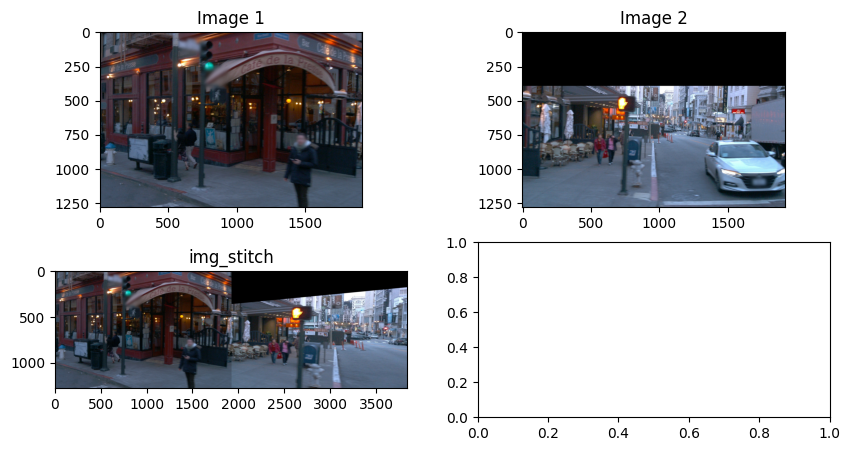

In [256]:
time_stamps = [f for f in os.listdir(pred_path) if os.path.isdir(os.path.join(pred_path, f))]
time_stamps = sorted(time_stamps)
for i, time_stamp in enumerate(time_stamps):
    if(i == 70):
        pred1 = cv2.imread(f"{pred_path}/{time_stamp}/{cam_name1}_panoptic_prediction.png")
        img1 = cv2.imread(f"{image_path}/{time_stamp}/{cam_name1}.jpg")
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        semantic_pred1 = pred1[:, :, 0]
        instance_pred1 = pred1[:, :, 1]
        img1 = _pad_to_common_shape(img1)
        
        pred2 = cv2.imread(f"{pred_path}/{time_stamp}/{cam_name2}_panoptic_prediction.png")
        img2 = cv2.imread(f"{image_path}/{time_stamp}/{cam_name2}.jpg")
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        semantic_pred2 = pred2[:, :, 0]
        instance_pred2 = pred2[:, :, 1]
        img2 = _pad_to_common_shape(img2)
        
        fig, axs = plt.subplots(2, 2, figsize=(10, 5))
        
        axs[0][0].imshow(img1)
        axs[0][0].set_title('Image 1')
        
        axs[0][1].imshow(img2)
        axs[0][1].set_title('Image 2')
        
        H = getHomography(img1, img2, K, R1, R2)
        print(H)
#         np.save("H_FRONT_RIGHT_and_SIDE_RIGHT", H)
        img_stitch = warpImage(img1, img2, H)
        print(img_stitch.shape)
        axs[1][0].imshow(img_stitch)
        axs[1][0].set_title('img_stitch')
        
        

In [252]:
# r1 = R.from_euler('y', 90, degrees=True)
# r2 = R.from_euler('x', 90, degrees=True)
# t = R.from_euler('z', -44, degrees=True)
# print(t.as_matrix())
# t1 = R.from_euler('y', 44, degrees=True)
# print(t1.as_matrix())
# t2 = t * r1 * r2
# print(np.round(t2.as_matrix(), 3))

In [29]:
# R_2to1 = R1 @ np.linalg.inv(R2)
# print(R_2to1)
# H = K @ R_2to1 @ np.linalg.inv(K)
# H /= H[2][2]

In [30]:
# relative_R = R1 @ np.linalg.inv(R2)
# theta = np.arctan2(relative_R[0][1] , relative_R[0][0])
# r = R.from_euler('y', -theta, degrees=False)
# R_2to1 = r.as_matrix()
# H = K @ R_2to1 @ np.linalg.inv(K)
# H /= H[2][2]

In [6]:
# p1 = np.array([0, 0, 0, 1]).T
# extr = cam_extrinsic[0]
# intr = cam_intrinsic[0]
# np.arctan2(extr[0][1] , extr[0][0]) * 180 / np.pi